<a href="https://colab.research.google.com/github/morkeDev/Sentiment-Analysis/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources

Importing Libraries

In [1]:
import pandas as pd
import string
import numpy as np
import nltk
import itertools

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Mounting Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading .csv files

In [3]:
dfTrain = pd.read_csv('/content/drive/My Drive/train.csv', names=['reviews', 'labels'])
dfTest = pd.read_csv('/content/drive/My Drive/test.csv', names=['reviews', 'labels'])
dfVal = pd.read_csv('/content/drive/My Drive/val.csv', names=['reviews', 'labels'])

# Data Analysis

In [4]:
print(dfTrain.shape) # checks the shape of the frame
print(dfTest.shape) 
print(dfVal.shape) 

(1400, 2)
(401, 2)
(200, 2)


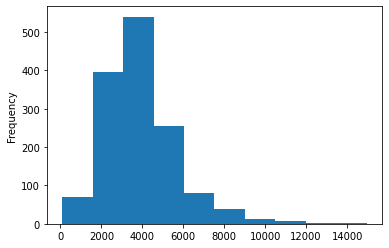

In [5]:
dfTrain['reviews'].str.len().plot.hist() # frequence of characters in the dataframe

In [6]:
dfTrain

,reviews,labels
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1
...,...,...
1395,it's been hours since i returned from the much...,0
1396,i'm not sure who the genius is who came up wit...,0
1397,the classic story & the production which ruine...,0
1398,"according to popular film opinion , a film's g...",0


Frequently appearing words and their count

In [7]:
from collections import Counter
Counter(" ".join(dfTrain['reviews']).split()).most_common(20)

[(',', 54504),
 ('the', 53659),
 ('.', 46149),
 ('a', 26795),
 ('and', 24917),
 ('of', 23828),
 ('to', 22506),
 ('is', 17733),
 ('in', 15235),
 ('"', 12420),
 ('that', 10718),
 ('it', 8595),
 (')', 8410),
 ('(', 8307),
 ('as', 7888),
 ('with', 7649),
 ('for', 6969),
 ('this', 6911),
 ('his', 6685),
 ('film', 6270)]

# Data preprocessing

Subsampling the validation dataset

In [8]:
dfVal = dfVal.sample(n=50) 

print(dfVal.shape) 

(50, 2)


Storing the reviews and labels in an object


In [9]:
train_reviews = dfTrain['reviews']
y_train = dfTrain['labels']

val_reviews = dfVal['reviews']
y_val = dfVal['labels']

train_reviews.head()

0    note : some may consider portions of the follo...
1    note : some may consider portions of the follo...
2    every once in a while you see a film that is s...
3    when i was growing up in 1970s , boys in my sc...
4    the muppet movie is the first , and the best m...
Name: reviews, dtype: object

Removing punctuation and stopwords



In [10]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_eng = set(stopwords.words("english"))

def preprocessing(text):
    text = text.lower() # convert to lowercase
    text = re.sub("[^a-z]", " ", text) # removing punctuation and white spaces
    words = [word for word in text.split() if word not in stopwords_eng] # splitting the sentences into words and removing the stopwords
    text = " ".join(words) # rejoin words into sentences
    return text

train_reviews = train_reviews.map(preprocessing)
val_reviews = val_reviews.map(preprocessing)

train_reviews.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    note may consider portions following text spoi...
1    note may consider portions following text spoi...
2    every see film effective delivering goods easy...
3    growing boys school used divide two groups bas...
4    muppet movie first best movie among ever growi...
Name: reviews, dtype: object

Checking the character length after the preprocessing has been done.

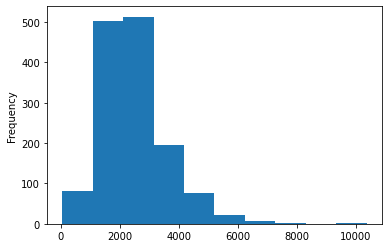

In [11]:
train_reviews.str.len().plot.hist()

# **Tokenization**

In [12]:
num_words = 5500
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(train_reviews)
X_train = pd.Series(tokenizer.texts_to_sequences(train_reviews))
X_val = pd.Series(tokenizer.texts_to_sequences(val_reviews))

X_train

0       [397, 76, 1216, 4019, 676, 3568, 2555, 5012, 4...
1       [397, 76, 1216, 4019, 676, 3568, 2555, 5012, 4...
2       [56, 18, 1, 591, 2624, 4561, 574, 984, 5023, 4...
3       [2021, 1144, 236, 265, 14, 4200, 220, 38, 40, ...
4       [3, 17, 32, 3, 481, 90, 2021, 893, 40, 3, 415,...
                              ...                        
1395    [490, 94, 3262, 10, 4846, 855, 856, 523, 734, ...
1396    [160, 1535, 652, 237, 5027, 1180, 2137, 439, 2...
1397    [377, 8, 332, 2899, 2633, 1463, 377, 35, 194, ...
1398    [2727, 664, 1, 1471, 1, 3329, 1877, 6, 66, 330...
1399    [49, 611, 25, 555, 18, 3, 44, 379, 117, 1374, ...
Length: 1400, dtype: object

In [13]:
print(num_words)

5500


In [14]:
maxlen = 250
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val_pad = pad_sequences(X_val, padding='post', maxlen=maxlen)

X_train_pad

array([[2412, 5014,  756, ...,   24,   90,   43],
       [ 317, 5017, 1218, ..., 4026,    1,   65],
       [ 430,  228,  206, ..., 1711,    2,   65],
       ...,
       [2651,  890, 3665, ..., 2618,   18, 1284],
       [2524,  310,  357, ..., 3872,    2,  304],
       [ 350,  202,    3, ...,  526, 3293,  977]], dtype=int32)

# **Building/Fitting the model**

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D, Dropout

def movie_review_classifier():
    model = Sequential()

    model.add(Embedding(input_dim=num_words, input_length=maxlen, output_dim=64)) 
    model.add(LSTM(32, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [16]:
model = movie_review_classifier()
training = model.fit(x=X_train_pad, y=y_train ,epochs=5, validation_data = (X_val_pad, y_val), shuffle=True, verbose=True, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           352000    
                                                                 
 lstm (LSTM)                 (None, 250, 32)           12416     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

In [17]:
import matplotlib.pyplot as plt

def plot_history(training):
# Plot history: MAE
  plt.plot(training.history['accuracy'], label='Training Accuracy')
  plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
  plt.plot(training.history['val_loss'], label='Validation Loss')
  plt.title('Movie Review Classifier')
  plt.ylabel('Percent')
  plt.xlabel('Epoch')
  plt.legend(loc="lower right")
  plt.show()
  

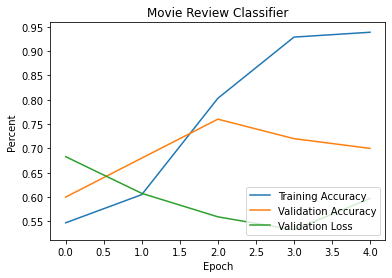

In [18]:
plot_history(training)

# **Testing the model**

In [19]:
dfTest

dfTest = dfTest.loc[1: , : ] # removing the first row of the dataset, since it is irrelevant

test_reviews = dfTest['reviews']
test_labels = dfTest['labels']

Preprocessing the test dataset

In [20]:
test = dfTest.reviews.map(preprocessing)

test.head()

1    wild things suspenseful thriller starring matt...
2    know already opened december finally got aroun...
3    shocking carlito way good gotten bit bad rap b...
4    uncompromising french director robert bresson ...
5    aggressive bleak unrelenting film interracial ...
Name: reviews, dtype: object

Tokenization

In [21]:
X_test_seq = tokenizer.texts_to_sequences(test)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

Prediction

In [22]:
pred = model.predict(x=X_test_pad)
round_predict = (pred >= 0.5) * 1 # the 

Values in a confusion matrix must be from the same type

In [23]:
test_labels = np.array(test_labels)
test_labels = test_labels.astype(int)

Creating a confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=test_labels, y_pred=round_predict)

In [25]:
# This section of code is copied from https://deeplizard.com/learn/video/km7pxKy4UHU

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
cm_plot_labels = ['positive review','negative review'] # setting up the labels for the plot

Confusion matrix, without normalization
[[154  32]
 [ 62 152]]


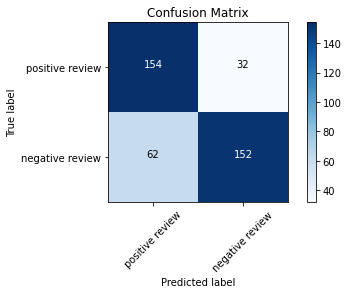

In [27]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') # printing the confusion matrix

In [28]:
# Evaluating the model 

loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, test_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9714
Testing Accuracy:  0.7650


In [29]:
# Predicting all values and writing them to a csv file

results = pd.DataFrame({"review": dfTest.reviews, "label": round_predict.flatten()})
results.to_csv('/content/drive/My Drive/predictions.csv', index=False)